In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"riyashah25","key":"01889b5938d0e06123c82b67403f2efd"}'}

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list -s 'UTKFace'

ref                                             title                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------  ----------------------------------  -----  -------------------  -------------  ---------  ---------------  
jangedoo/utkface-new                            UTKFace                             331MB  2018-08-16 19:05:30          10008        137  0.6875           
ayushkumar0801/utkface-uncropped-dataset        UTKFace Uncropped Dataset             1GB  2021-05-16 07:28:58             53          5  0.625            
abhikjha/utk-face-cropped                       UTK Face Cropped                    232MB  2019-05-03 18:35:14           1541         29  0.5625           
ayushkumar0801/utk-face-extracted-info          UTK Face Extracted Info             399KB  2021-06-02 13:10:48             55          3  0.9705882        
afsonamimi/utkface                              utkface         

In [6]:
!kaggle datasets download -d 'jangedoo/utkface-new'

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip utkface-new.zip

Archive:  utkface-new.zip
replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os 
import seaborn as sns

import tensorflow
from tensorflow.keras.preprocessing.image import load_img    # load image in pil formate (PIL moudule)
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input , Dense , Conv2D , Dropout , Flatten , MaxPooling2D

In [2]:
# extract all images from the path , age and gender
# image name = age_gender_enthists_unique name.jpg
Images_path = '/content/crop_part1/'
paths = []
ages = []
genders = []
for image in os.listdir(Images_path):
  img_path = os.path.join(Images_path,image)
  temp = image.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  paths.append(img_path)
  ages.append(age)
  genders.append(gender)


In [3]:
# create data frame

df = pd.DataFrame()
df['image_path'] = paths
df['Age'] = ages
df['Gender'] = genders
df.head()

,image_path,Age,Gender
0,/content/crop_part1/24_1_2_20170105162251371.j...,24,1
1,/content/crop_part1/21_1_2_20170104021056028.j...,21,1
2,/content/crop_part1/9_1_0_20170105000600802.jp...,9,1
3,/content/crop_part1/6_1_2_20161219151445563.jp...,6,1
4,/content/crop_part1/21_1_4_20170103223208902.j...,21,1


In [7]:
len(paths)

9780

In [8]:
# map labels for gender 
gender_dict = {0:"Male" , 1:"Female"}

## Exploratory Data Analysis

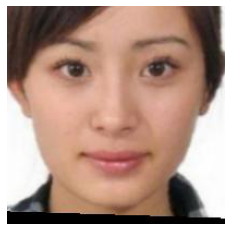

In [9]:
from PIL import Image

img = Image.open(df['image_path'][1])
plt.axis('off')
plt.imshow(img)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


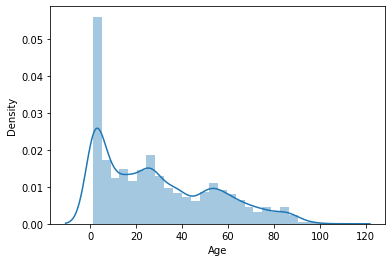

In [10]:
sns.distplot(df['Age'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


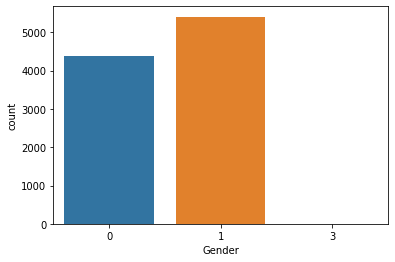

In [11]:
sns.countplot(df['Gender'])


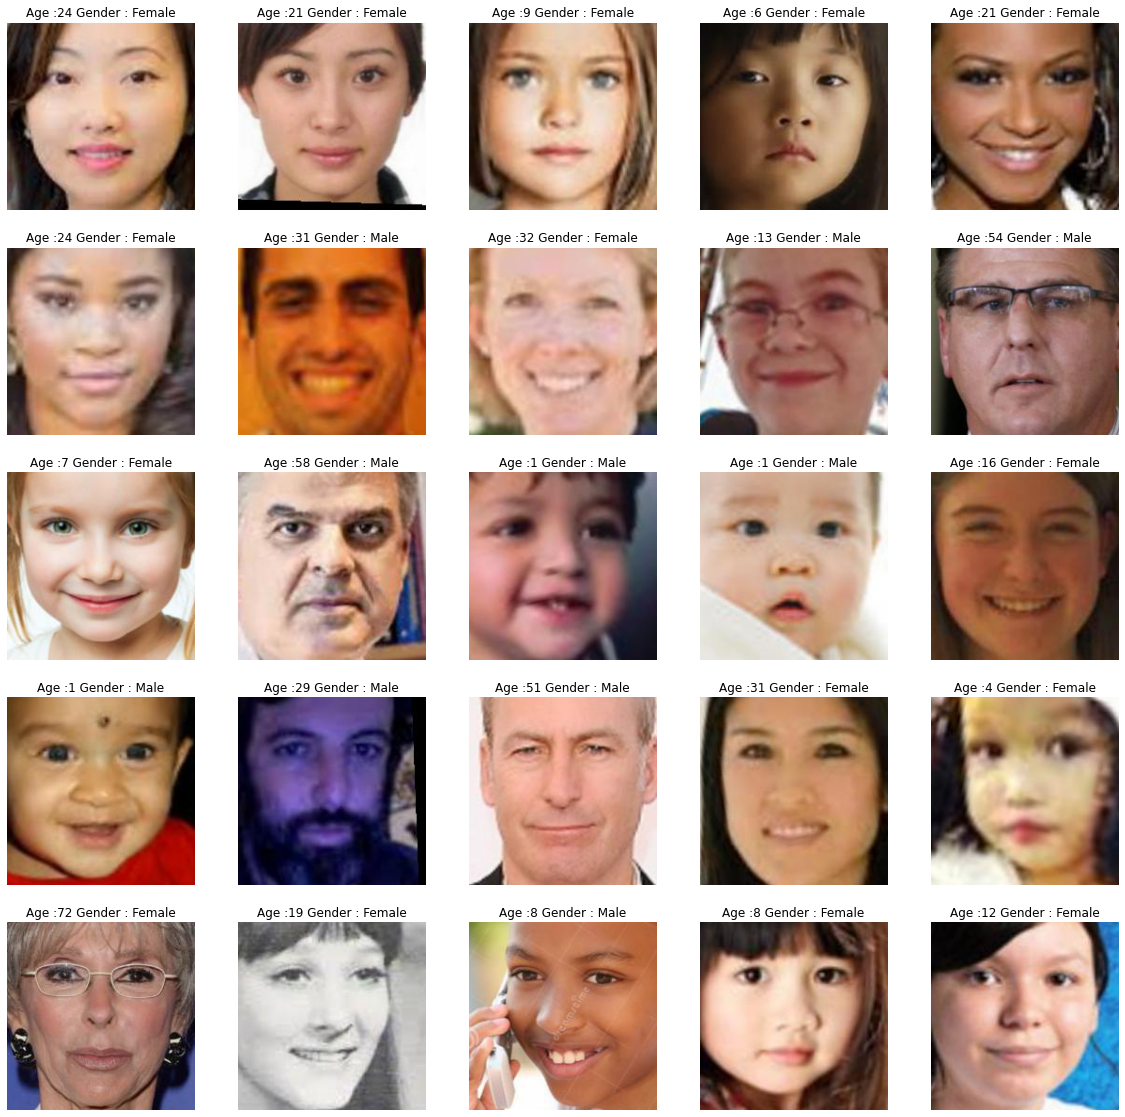

In [12]:
# to display grid of images 

plt.figure(figsize = (20,20))
files = df.iloc[:25]
files.itertuples()
for index , file , age , gender in files.itertuples():
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title(f"Age :{age} Gender : {gender_dict[gender]}")
  plt.axis('off')

## Feature Extraction

In [13]:
def extract_feature(image):
  features = []
  for image in image:
    img = load_img(image , grayscale = True)
    img = img.resize((128,128))
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features),128,128,1)
  return features

In [14]:
X = extract_feature(df['image_path'])


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [15]:
X.shape

(9780, 128, 128, 1)

In [16]:
# normalize the images
X = X/255.0


In [17]:
y_gender = np.array(df['Gender'])
y_age = np.array(df['Age'])

In [18]:
input_shape = (128,128,1)
type(input_shape)

tuple

## Model Creation

In [19]:
inputs = Input(input_shape)
# convolution layers

conv_1 = Conv2D(32 , kernel_size=(4,4) , activation = 'relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64 , kernel_size=(4,4) , activation = 'relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128 , kernel_size=(4,4) , activation = 'relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256 , kernel_size=(4,4) , activation = 'relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers 
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1 , activation = 'sigmoid' , name = 'gender_out')(dropout_1)
output_2 = Dense(1 , activation = 'relu' , name = 'age_out')(dropout_2)

model = Model(inputs = [inputs] , outputs = [output_1 , output_2])
model.compile(loss = ['binary_crossentropy' , 'mse'] , optimizer = 'adam' , metrics = ['accuracy'])

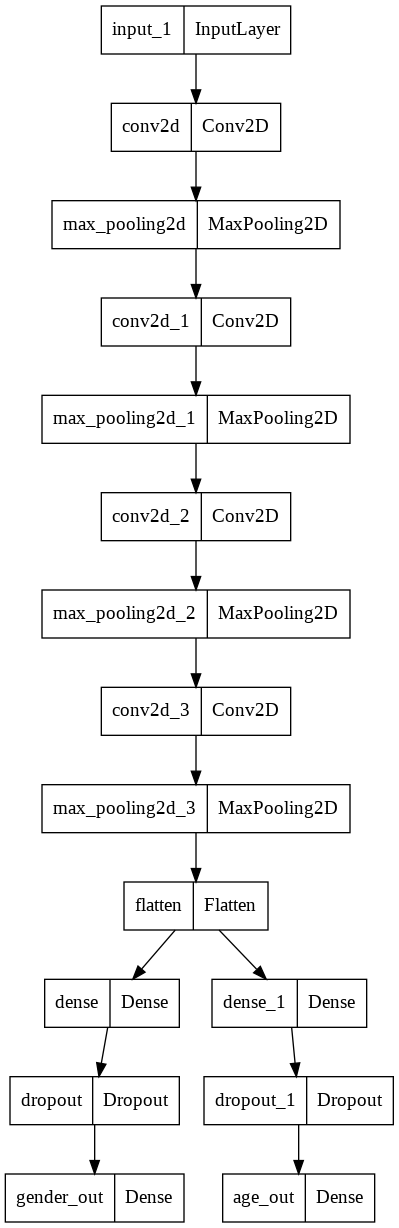

In [20]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)


In [21]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)


Epoch 1/30
245/245 [==============================] - 13s 37ms/step - loss: 694.7585 - gender_out_loss: 0.7175 - age_out_loss: 694.0410 - gender_out_accuracy: 0.5382 - age_out_accuracy: 0.1120 - val_loss: 722.0634 - val_gender_out_loss: 0.6910 - val_age_out_loss: 721.3723 - val_gender_out_accuracy: 0.5501 - val_age_out_accuracy: 0.1191
Epoch 2/30
245/245 [==============================] - 6s 26ms/step - loss: 509.2624 - gender_out_loss: 0.6662 - age_out_loss: 508.5963 - gender_out_accuracy: 0.5900 - age_out_accuracy: 0.1075 - val_loss: 328.1129 - val_gender_out_loss: 0.5938 - val_age_out_loss: 327.5192 - val_gender_out_accuracy: 0.6733 - val_age_out_accuracy: 0.1125
Epoch 3/30
245/245 [==============================] - 7s 28ms/step - loss: 319.3424 - gender_out_loss: 0.5787 - age_out_loss: 318.7635 - gender_out_accuracy: 0.6812 - age_out_accuracy: 0.0906 - val_loss: 236.9283 - val_gender_out_loss: 0.5421 - val_age_out_loss: 236.3862 - val_gender_out_accuracy: 0.6973 - val_age_out_accur

## plot results

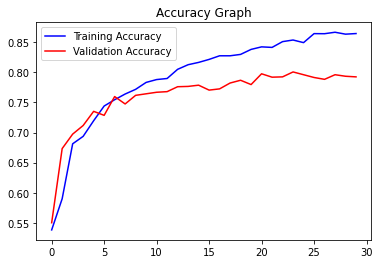

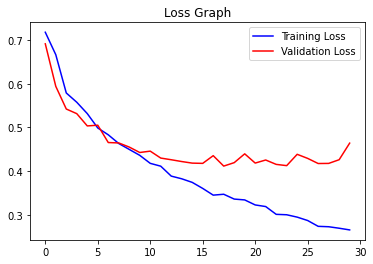

In [22]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


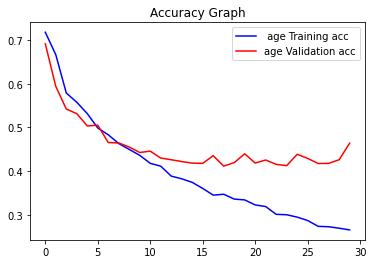

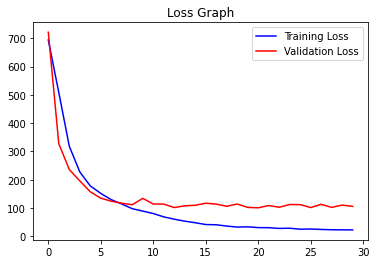

In [24]:
# plot results for age
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label=' age Training acc')
plt.plot(epochs, val_loss, 'r', label='age Validation acc')
plt.title('Accuracy Graph')
plt.legend()
plt.show()


loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


## Prediction image 


original gender:  Female original age :  72
Predicted Gender: Female Predicted Age: 71


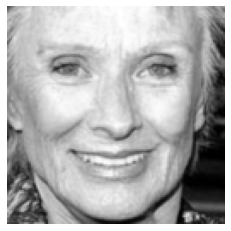

In [28]:

img_index = 7544
print("original gender: " , gender_dict[y_gender[img_index]] , "original age : ", y_age[img_index])
# predict from model 
pred = model.predict(X[img_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[img_index].reshape(128, 128), cmap='gray');